In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import warnings

from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_fscore_support,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from itertools import combinations

In [4]:
warnings.filterwarnings("ignore")

In [48]:
df1 = pd.read_csv(r"D:\Đề thi chung kết\train_1.csv")
df2 = pd.read_csv(r"D:\Đề thi chung kết\train_2.csv")
df_predict = pd.read_csv(r"D:\Đề thi chung kết\predict.csv")

# Phân tích mô tả (Exploratory Data Analysis (EDA) )

In [50]:
df_EDA = pd.merge(df1, df2, on='Case_ID', how='inner')
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39528 entries, 0 to 39527
Data columns (total 86 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Case_ID                       39528 non-null  int64  
 1   Total_TL                      39528 non-null  int64  
 2   Tot_Closed_TL                 39528 non-null  int64  
 3   Tot_Active_TL                 39528 non-null  int64  
 4   Total_TL_opened_L6M           39528 non-null  int64  
 5   Tot_TL_closed_L6M             39528 non-null  int64  
 6   pct_tl_open_L6M               39528 non-null  float64
 7   pct_tl_closed_L6M             39528 non-null  float64
 8   pct_active_tl                 39528 non-null  float64
 9   pct_closed_tl                 39528 non-null  float64
 10  Total_TL_opened_L12M          39528 non-null  int64  
 11  Tot_TL_closed_L12M            39528 non-null  int64  
 12  pct_tl_open_L12M              39528 non-null  float64
 13  p

## Kiểm tra giá trị trùng lặp

In [52]:
# Đảm bảo không có cột trùng lặp sau khi gộp
df_EDA = df_EDA.loc[:,~df_EDA.columns.duplicated()]
print(f"Number of rows and columns in the combined DataFrame: {df_EDA.shape}")

Number of rows and columns in the combined DataFrame: (39528, 86)


## Kiểm tra missing values

In [54]:
missing_values = df_EDA.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Case_ID                0
Total_TL               0
Tot_Closed_TL          0
Tot_Active_TL          0
Total_TL_opened_L6M    0
                      ..
HL_Flag                0
GL_Flag                0
last_prod_enq2         0
first_prod_enq2        0
Approved_Flag          0
Length: 86, dtype: int64


## Kiểm tra và loại bỏ giá trị Outlier

In [56]:
# Loại bỏ các cột định tính
numeric_columns = df_EDA.select_dtypes(include=[np.number]).columns

# Kiểm tra các giá trị ngoại lai bằng IQR
Q1 = df_EDA[numeric_columns].quantile(0.25)
Q3 = df_EDA[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Điều kiện để xác định hàng có giá trị ngoại lai
condition = ~((df_EDA[numeric_columns] < (Q1 - 1.5 * IQR)) | (df_EDA[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Loại bỏ các hàng có giá trị ngoại lai
data = df_EDA[condition]
print(f"Number of rows after removing outliers: {data.shape[0]}")
print(data.head())

Number of rows after removing outliers: 2904
    Case_ID  Total_TL  Tot_Closed_TL  Tot_Active_TL  Total_TL_opened_L6M  \
4         5         1              0              1                    0   
10       11         1              0              1                    0   
14       15         1              0              1                    0   
65       66         1              0              1                    0   
68       69         2              2              0                    0   

    Tot_TL_closed_L6M  pct_tl_open_L6M  pct_tl_closed_L6M  pct_active_tl  \
4                   0              0.0                0.0            1.0   
10                  0              0.0                0.0            1.0   
14                  0              0.0                0.0            1.0   
65                  0              0.0                0.0            1.0   
68                  0              0.0                0.0            0.0   

    pct_closed_tl  ...  pct_PL_enq_L6m_of

## Thống kê mô tả

In [58]:
df_EDA.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Case_ID,39528.0,19764.500000,11410.895057,1.0,9882.75,19764.500,29646.25000,39528.0
Total_TL,39528.0,4.868751,7.220031,1.0,1.00,2.000,5.00000,235.0
Tot_Closed_TL,39528.0,2.777373,5.987964,0.0,0.00,1.000,3.00000,216.0
Tot_Active_TL,39528.0,2.091378,2.288112,0.0,1.00,1.000,3.00000,47.0
Total_TL_opened_L6M,39528.0,0.736339,1.296507,0.0,0.00,0.000,1.00000,27.0
...,...,...,...,...,...,...,...,...
pct_PL_enq_L6m_of_ever,39528.0,0.170809,0.350358,0.0,0.00,0.000,0.00000,1.0
pct_CC_enq_L6m_of_ever,39528.0,0.056505,0.213850,0.0,0.00,0.000,0.00000,1.0
max_unsec_exposure_inPct,39528.0,-45105.168735,49783.963367,-99999.0,-99999.00,0.335,2.15925,83672.1
HL_Flag,39528.0,0.270745,0.444350,0.0,0.00,0.000,1.00000,1.0


In [60]:
def remove_highly_correlated_features(df_EDA, threshold=0.8):
    corr_matrix = df_EDA.corr().abs()
    # Chọn tam giác trên của ma trận tương quan
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Tìm các cột có tương quan lớn hơn ngưỡng
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    # Loại bỏ các cột có tương quan cao
    df_reduced = df_EDA.drop(columns=to_drop)

    return df_reduced


In [62]:
# Danh sách các biến không cần thiết cần loại bỏ
unnecessary_columns = ['pct_tl_open_L6M', 'pct_tl_closed_L6M', 'pct_active_tl',
             'pct_closed_tl','pct_tl_open_L12M',
             'pct_tl_closed_L12M','pct_of_active_TLs_ever', 'pct_opened_TLs_L6m_of_L12m', 'pct_currentBal_all_TL','pct_PL_enq_L6m_of_L12m',
             'pct_CC_enq_L6m_of_L12m', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever', 'CC_enq', 'CC_enq_L6m', 'CC_enq_L12m', 'PL_enq', 'PL_enq_L6m', 'PL_enq_L12m','enq_L12m', 'enq_L6m', 'enq_L3m']

# Loại bỏ các biến không cần thiết từ dataframe
df_EDA = df_EDA.drop(columns=unnecessary_columns)

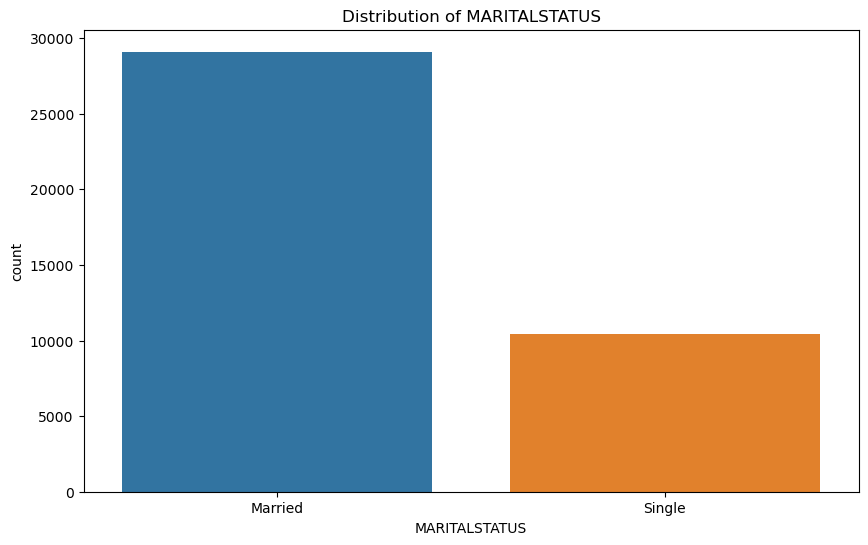

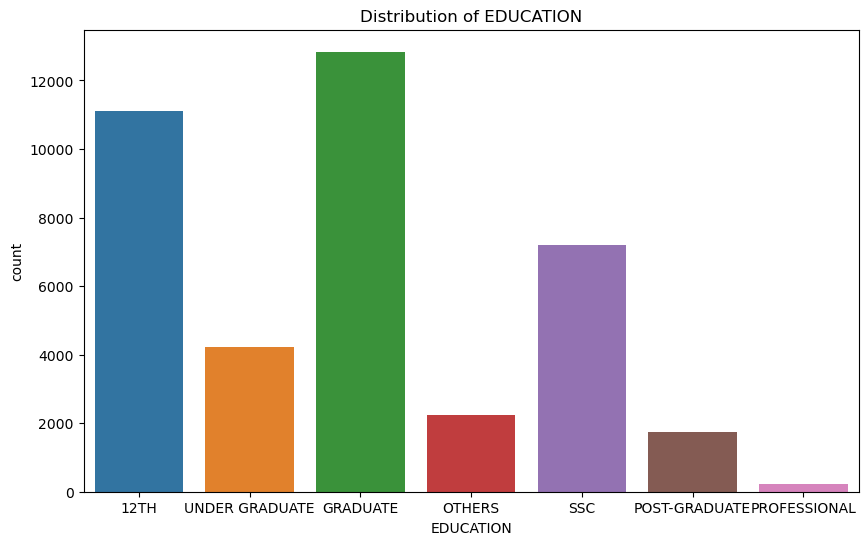

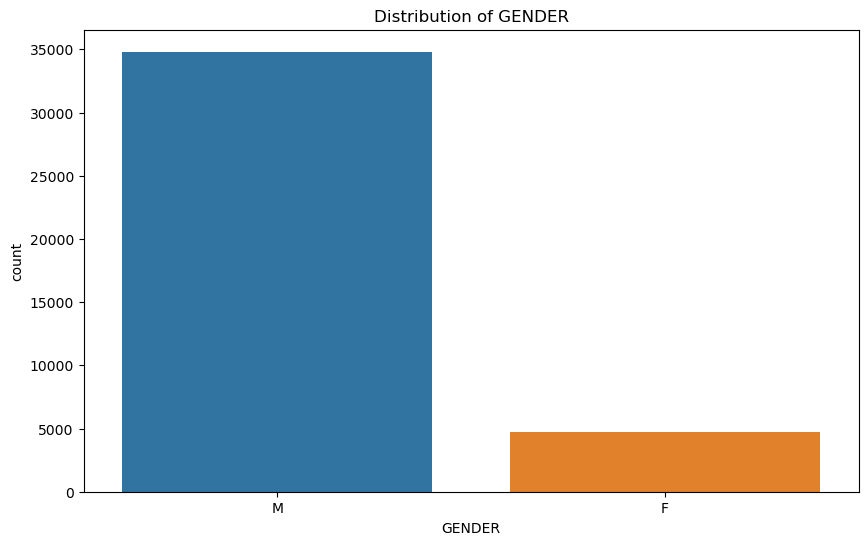

In [64]:
# Kiểm tra các biến phân loại và phân phối
categorical_vars = ['MARITALSTATUS', 'EDUCATION', 'GENDER']
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=var, data=df2)
    plt.title(f'Distribution of {var}')
    plt.show()

Nhận xét:
- Tình trạng hôn nhân: Đa số các khách hàng đều là những người đã kết hôn, có thể lý giải những khoảng vay xuất phát từ nhu cầu sinh hoạt gia đình và mua nhà/ mua xe để phục vụ cuộc sống.
- Trình độ học vấn: Đối tượng khách hàng chủ yếu là sinh viên mới ra trường (chưa có mức thu nhập cao lắm) và học sinh lớp 12.
Đáng chú ý, các đối tượng có thu nhập cao như các chuyên gia, sinh viên - nghiên cứu sinh sau đại học (những người có mức thu nhập tương đối khá hơn) thì lại chiếm tỉ trọng rất thấp.
- Giới tính: Kết quả thống kê cho thấy số lượng khách hàng là nam giới đóng chiếm một tỷ lệ áp đảo so với nữ giới (gấp khoảng 7 lần). Một con số khá lớn, có thể giải thích nguyên nhân của việc này là người đàn ông thường sẽ là người đảm nhận vị trí trụ cột tài chính cho gia đình, là người đứng tên ở các tài sản đảm bảo nên họ có xu hướng là người đứng ra để đại diện gia đình trong các khoản vay.

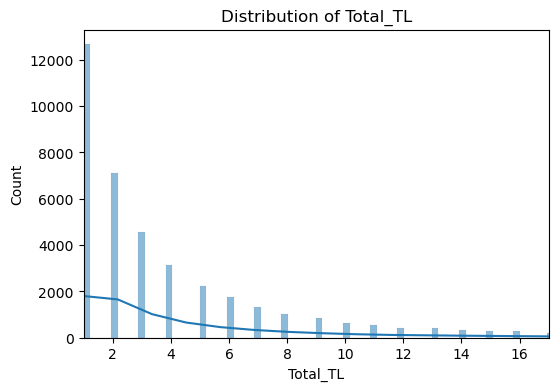

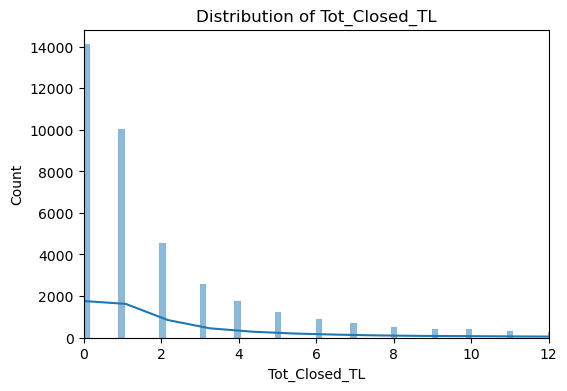

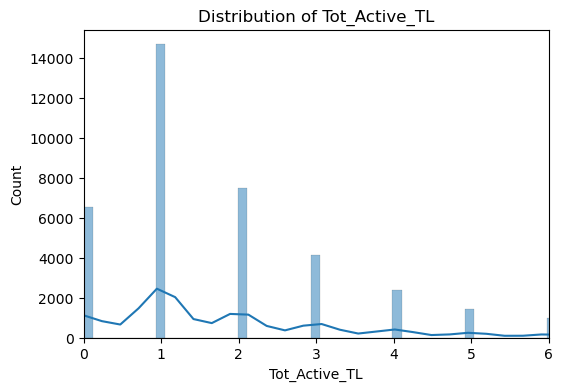

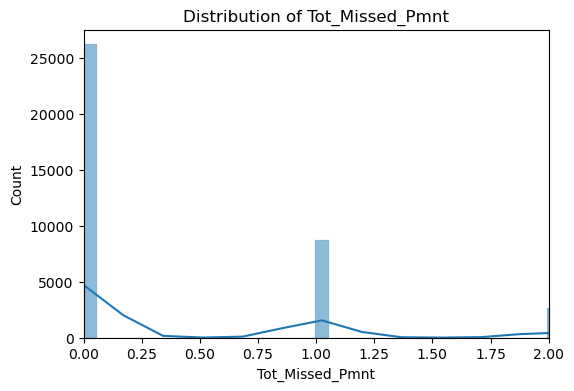

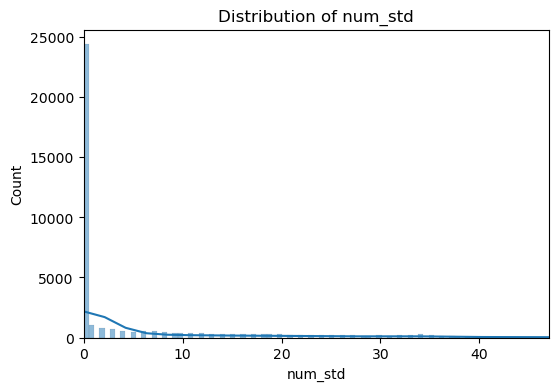

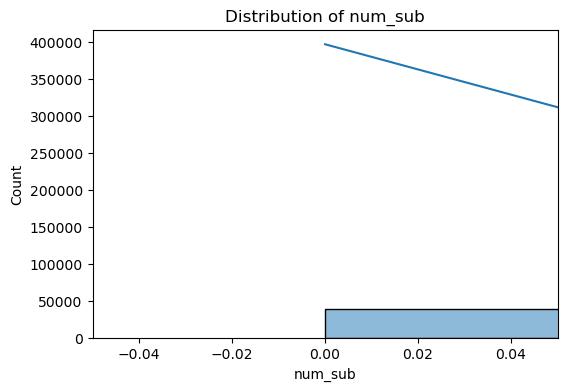

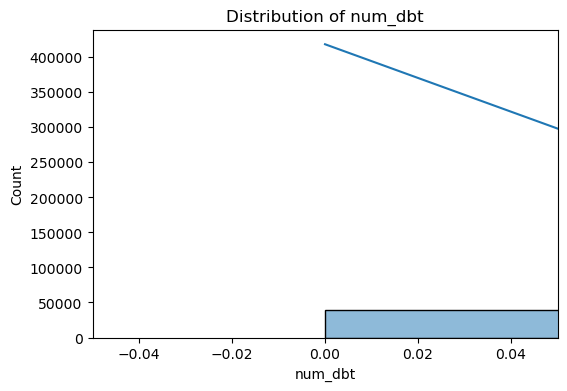

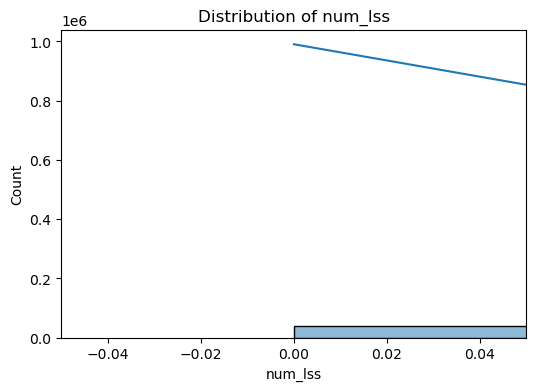

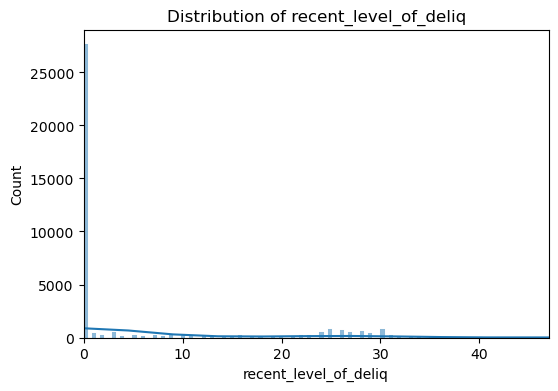

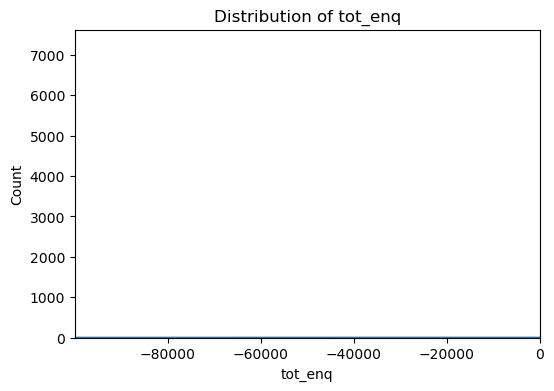

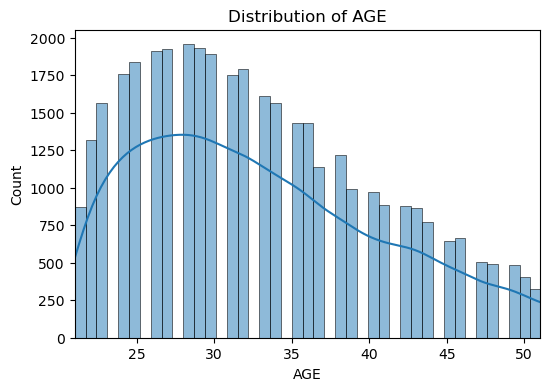

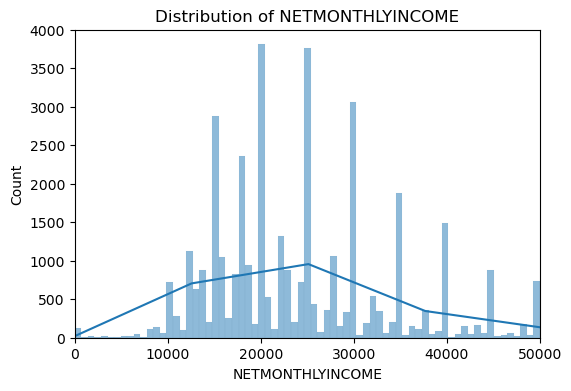

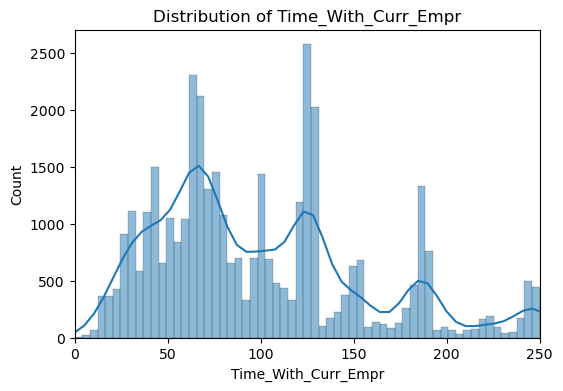

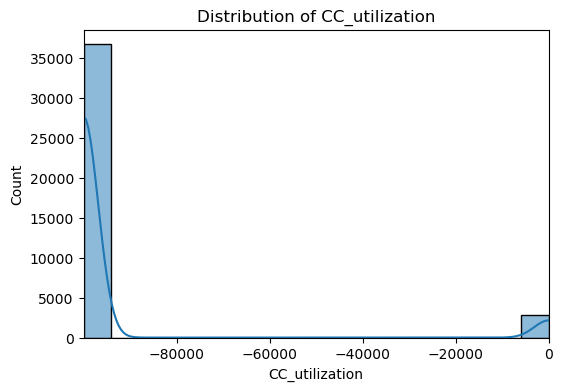

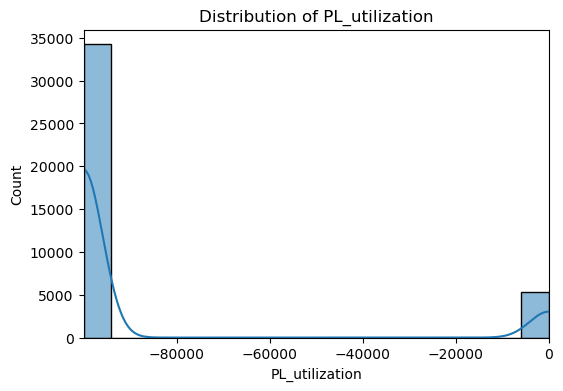

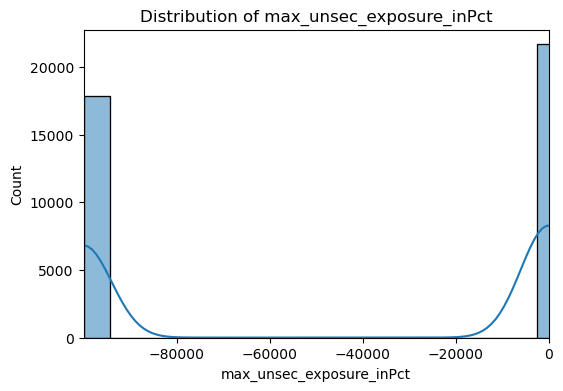

In [26]:
# Kiểm tra phân phối của các biến số liên tục
numerical_vars = ['Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL','Tot_Missed_Pmnt',
                  'num_std', 'num_sub', 'num_dbt', 'num_lss',
                  'recent_level_of_deliq', 'tot_enq', 'AGE', 'NETMONTHLYINCOME',
                  'Time_With_Curr_Empr', 'CC_utilization', 'PL_utilization', 'max_unsec_exposure_inPct']

for var in numerical_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_EDA[var].dropna(), kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlim(df_EDA[var].min(), df_EDA[var].quantile(0.95))
    plt.ylim(0, plt.ylim()[1])
    plt.show()

Tệp khách hàng của cty tài chính có một số đặc điểm nổi bật có thể kể tới như:
- Độ tuổi chủ yếu rơi vào khoảng 22 - 35: độ tuổi này thường có nhu cầu vay nhiều bởi đa số là sinh viên và người mới đi làm, mức thu nhập còn thấp.
- Mức thu nhập ròng theo tháng ghi nhận được không quá cao, rơi vào khoảng từ 1,5 triệu VND đến hơn 3 triệu VND.
- Thời gian làm việc liên tục gần đây: thời gian làm việc phân bố không đều, tập trung chủ yếu ở mức 40 giờ đến gần 125 giờ làm việc


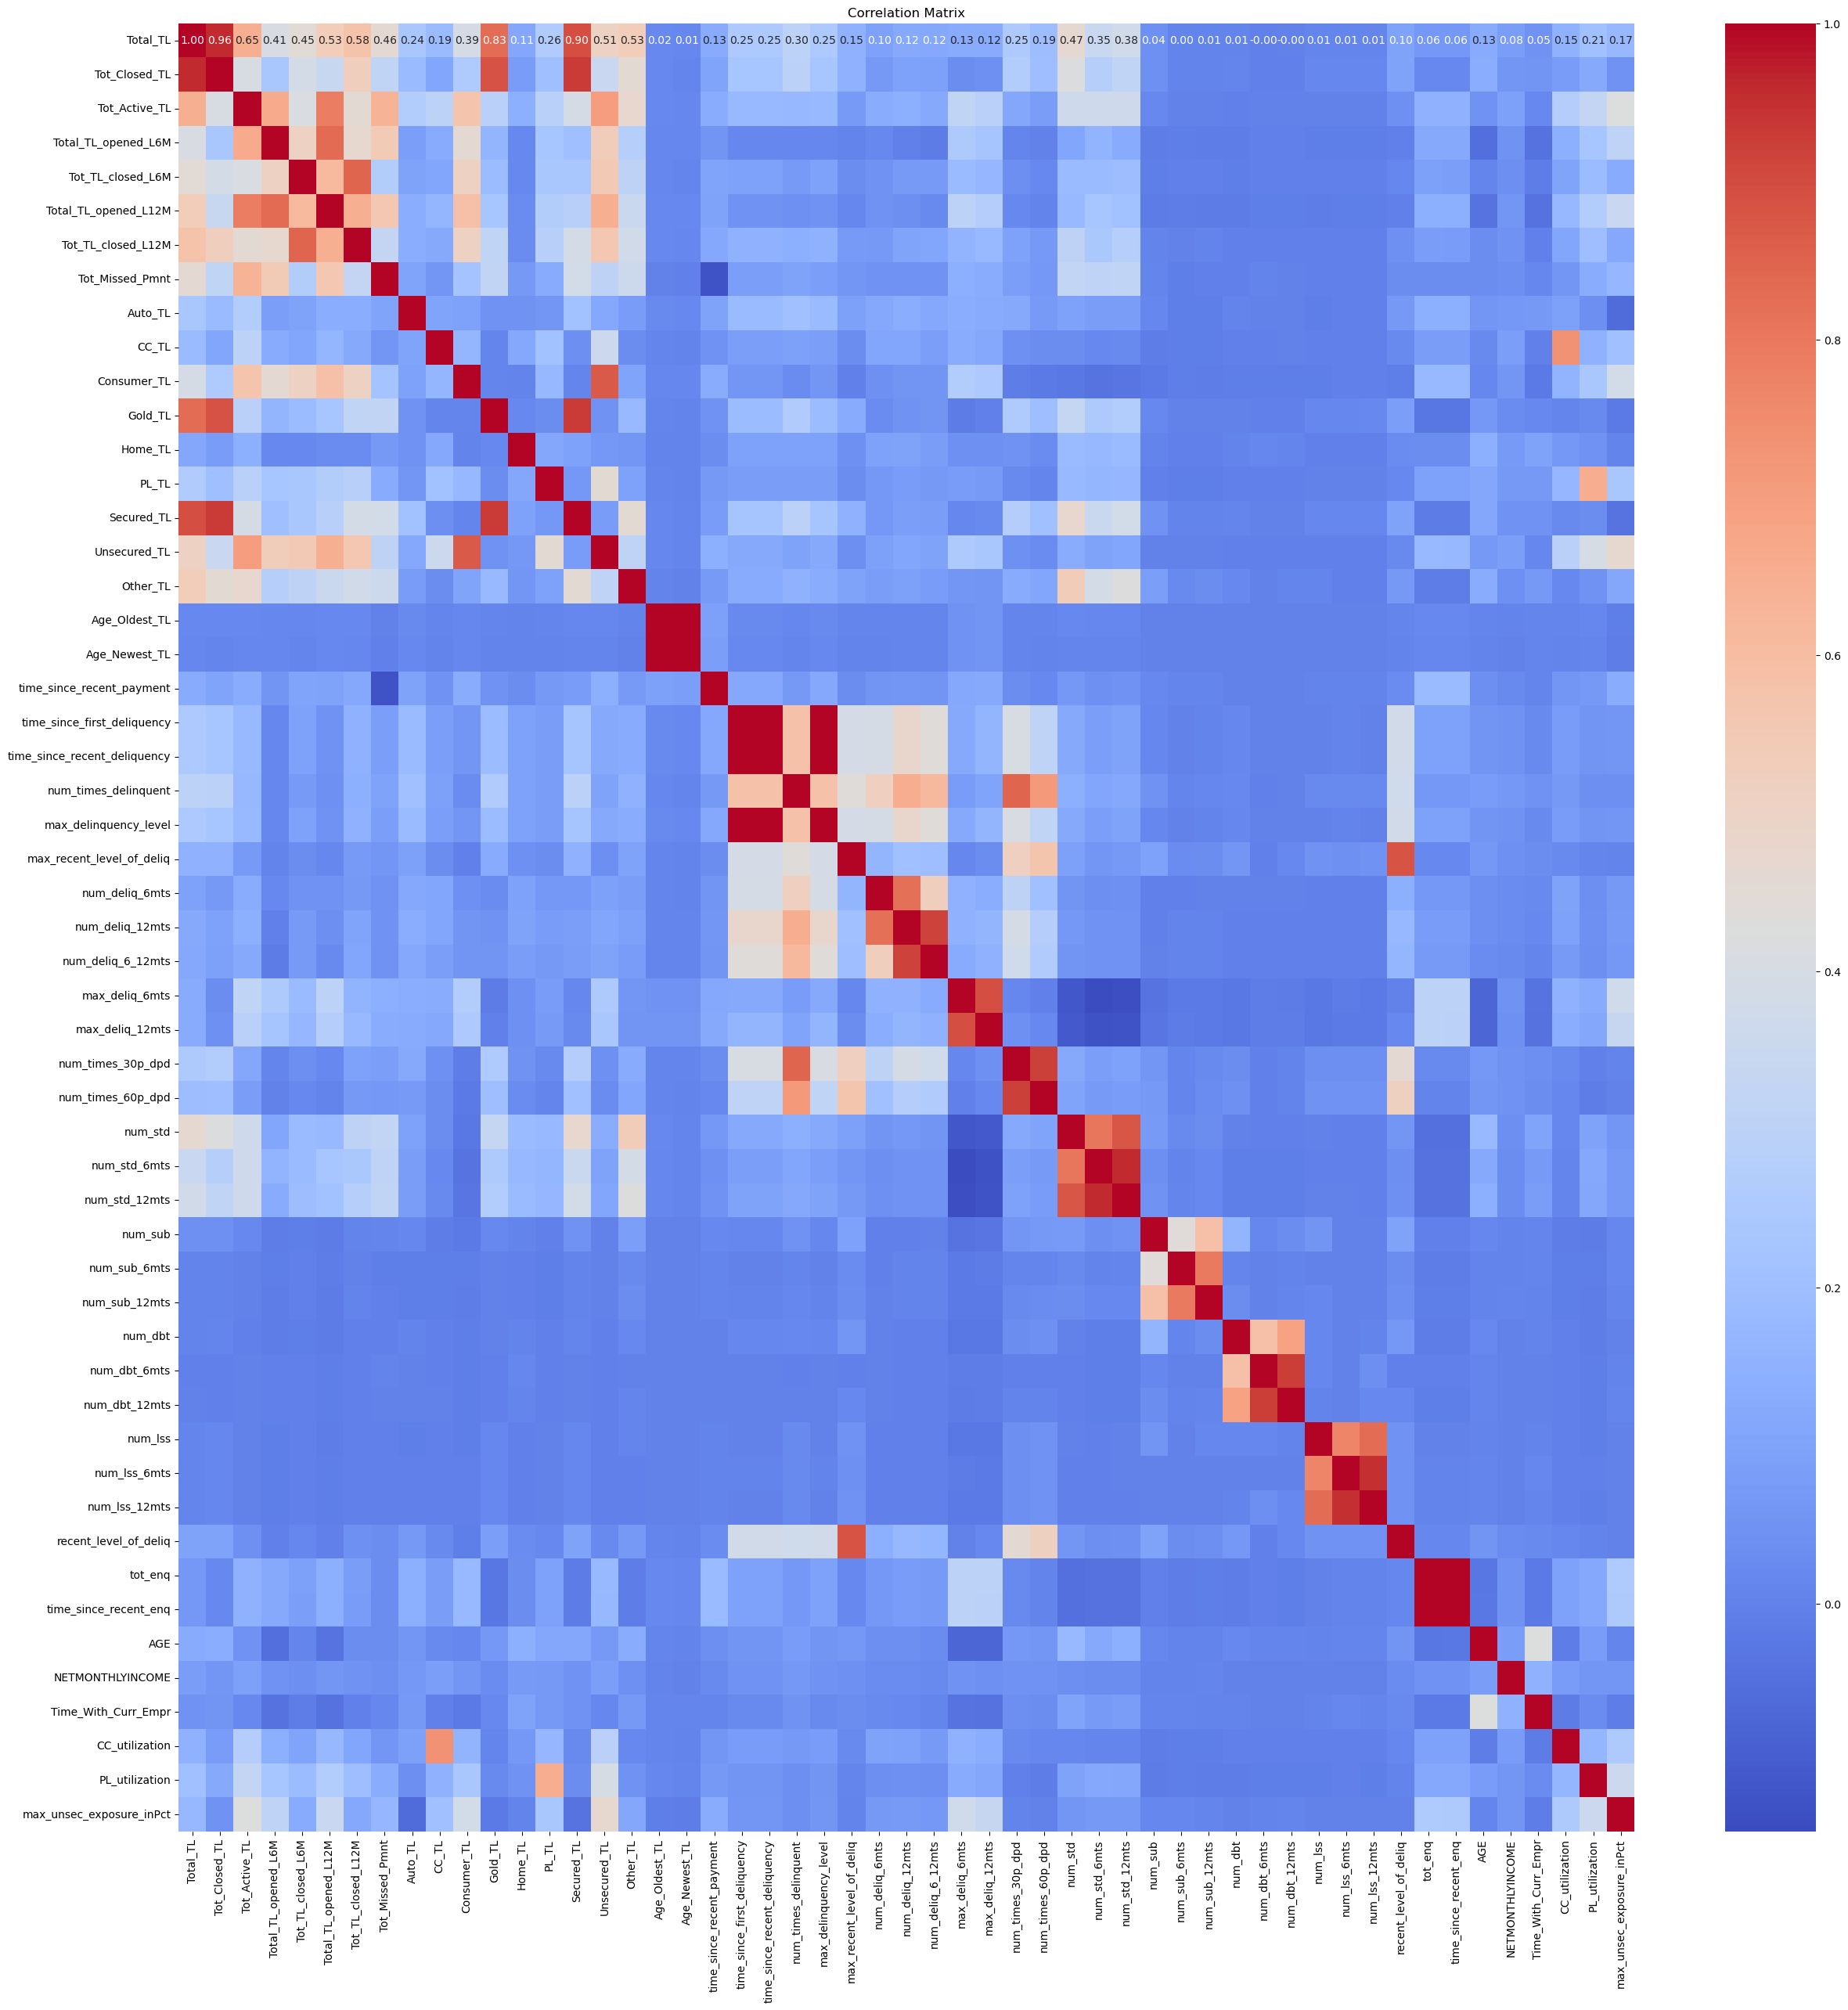

In [66]:
# Loại bỏ các biến định tính và các biến không liên quan
qualitative_vars = [
    'Case_ID', 'MARITALSTATUS', 'EDUCATION', 'GENDER', 'CC_Flag', 'PL_Flag',
    'HL_Flag', 'GL_Flag', 'last_prod_enq2', 'first_prod_enq2', 'Approved_Flag'
]
df3 = df_EDA.drop(columns=qualitative_vars, inplace=False, errors='ignore')

# Kiểm tra mối quan hệ giữa các biến số
corr_matrix = df3.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Mối quan hệ của 'Số tài khoản không có đảm bảo' và 'Số lượng khoản vay tiêu dùng'

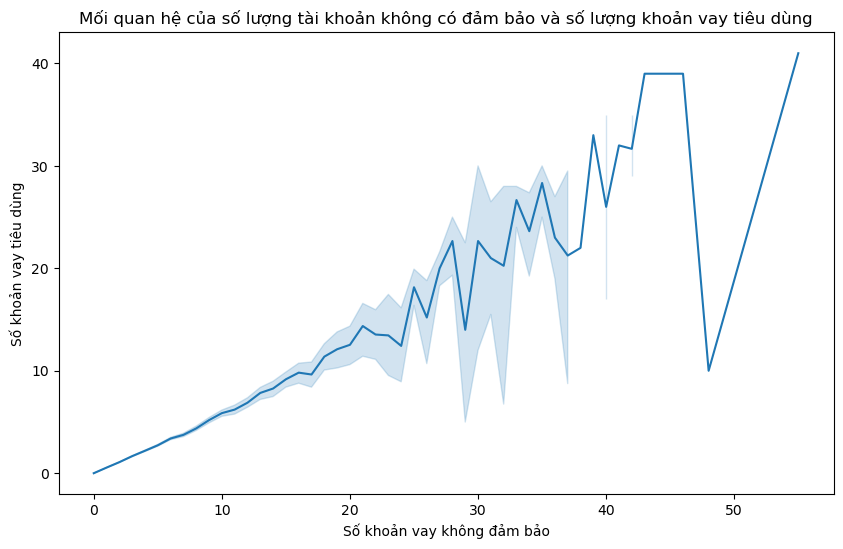

In [74]:
# biểu đồ scatter cho mối quan hệ giữa Unsecured_TL và Consumer_TL
plt.figure(figsize=(10, 6))
sns.lineplot(x='Unsecured_TL', y='Consumer_TL', data=df1)
plt.title('Mối quan hệ của số lượng tài khoản không có đảm bảo và số lượng khoản vay tiêu dùng')
plt.xlabel('Số khoản vay không đảm bảo')
plt.ylabel('Số khoản vay tiêu dùng')
plt.show()

Có thể thấy một mối tương quan dương của số lượng các khoản vay không có đảm bảo và số lượng khoản vay tiêu dùng của khách hàng. Điều này cho thấy rằng đa số các khách hàng vay nợ phục vụ cho mục tiêu tiêu dùng thường không đảm bảo được yếu tố an toàn về tài sản đảm bảo --> Có thể gây nguy cơ xảy ra nợ xấu

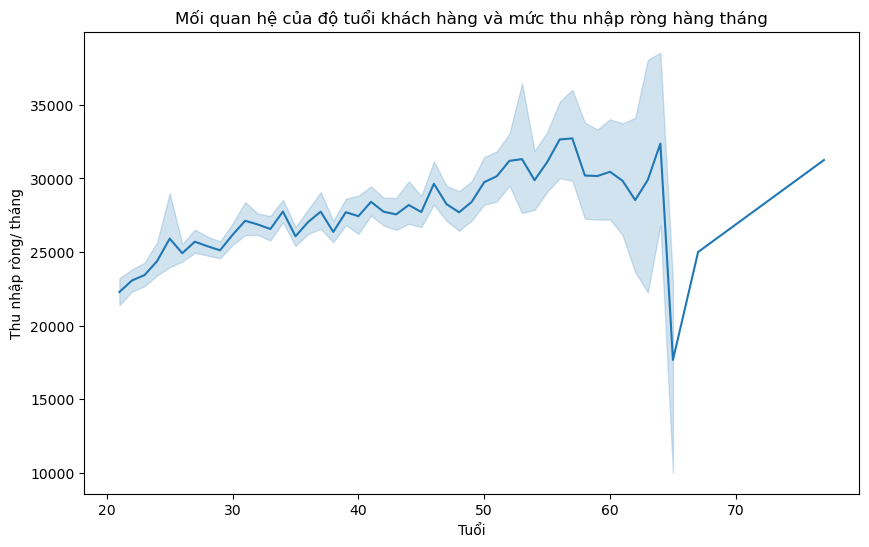

In [76]:
# biểu đồ scatter cho mối quan hệ giữa độ tuổi và thu nhập ròng hàng tháng
plt.figure(figsize=(10, 6))
sns.lineplot(x='AGE', y='NETMONTHLYINCOME', data=df_EDA)
plt.title('Mối quan hệ của độ tuổi khách hàng và mức thu nhập ròng hàng tháng')
plt.xlabel('Tuổi')
plt.ylabel('Thu nhập ròng/ tháng')
plt.show()

Độ tuổi 20 - 30 được ghi nhận là độ tuổi có mức thu nhập trung bình thấp nhất trong tệp khách hàng (thu nhập chưa ổn định và chi phí cho gia đình)
Sự khác biệt này không quá lớn đối với các khách hàng có độ tuổi tử 30 đến gần 50 tuổi.
Tuy nhiên, sau độ tuổi 50 thì mức thu nhập tăng lên đáng kể đặc biệt ở độ tuổi 60 cho thấy mức thu nhập đạt mức cao nhất (có thể vì kinh nghiệm và kĩ năng nghề nghiệp dày dặn, đạt được các vị trí cao mang lại một mức thu nhập cao)

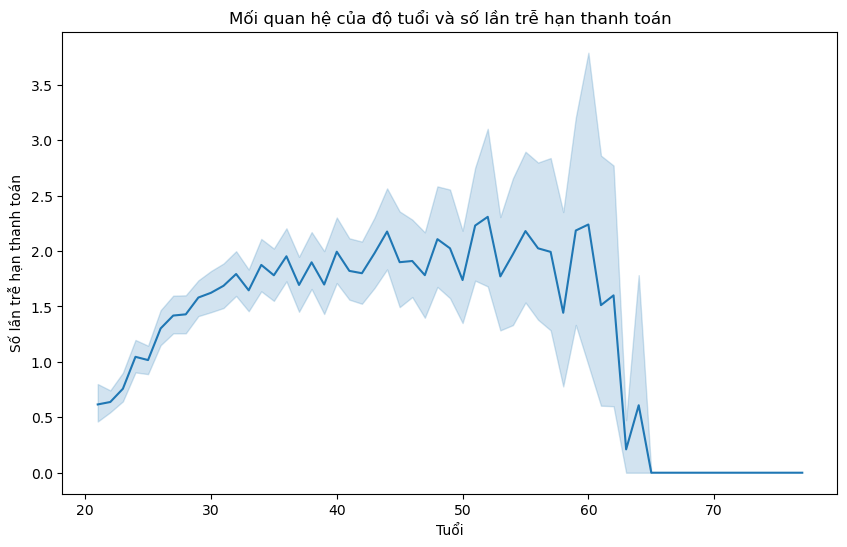

In [77]:
# biểu đồ scatter cho mối quan hệ giữa độ tuổi và số lần trễ hạn thanh toán
plt.figure(figsize=(10, 6))
sns.lineplot(x='AGE', y='num_times_delinquent', data=df_EDA)
plt.title('Mối quan hệ của độ tuổi và số lần trễ hạn thanh toán')
plt.xlabel('Tuổi')
plt.ylabel('Số lần trễ hạn thanh toán')
plt.show()

Insight khá thú vị cho thấy ở các độ tuổi càng cao thì số lần thanh toán trễ hạn lại càng nhiều. Nguyên nhân có thể vì họ quá bận rộn với công việc (độ tuổi 40 - 50) nên có ít thời gian kiểm tra các hóa đơn vay nợ hoặc không quá am hiểu về công nghệ nên dễ có khả năng quên hoặc thanh toán chậm (đối với nhóm khách hàng độ tuổi 50 - 60 trở lên)

Công ty tài chính nên lưu ý đặc điểm này để xây dựng các phương pháp nhắc nhở khách hàng khi đến hạn thanh toán.

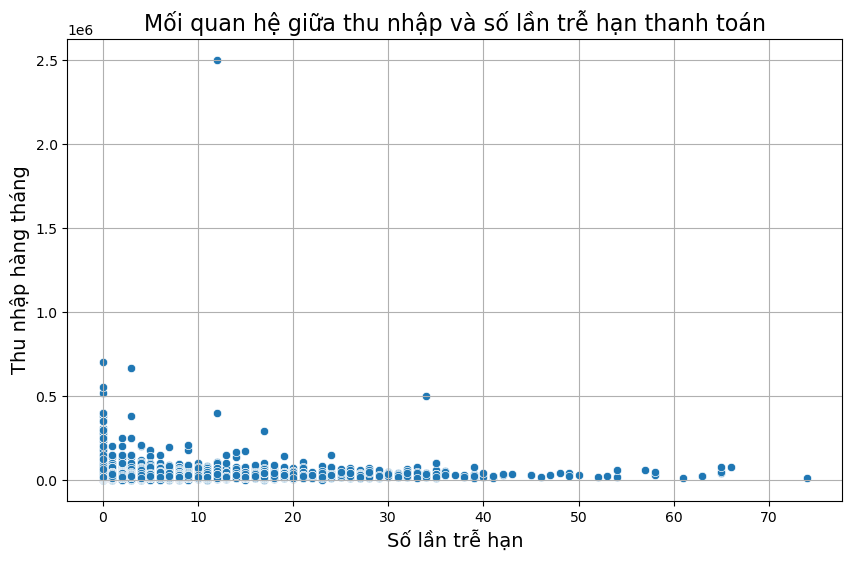

In [78]:
# Vẽ biểu đồ scatter cho mối quan hệ giữa thu nhập và số lần trễ hạn thanh toán
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_times_delinquent', y='NETMONTHLYINCOME', data=df_EDA)
plt.title('Mối quan hệ giữa thu nhập và số lần trễ hạn thanh toán', fontsize=16)
plt.xlabel('Số lần trễ hạn', fontsize=14)
plt.ylabel('Thu nhập hàng tháng', fontsize=14)
plt.grid(True)
plt.show()

Thu nhập càng cao thì số lần thanh toán trễ hạn càng thấp, điều này có thể hiểu và giải thích hợp lý được vì những khách hàng gặp khó khăn về tài chính thường không duy trì đủ nguồn tiền hoặc không có kế hoạch chuẩn bị tài chính cho các hóa đơn vay mượn như những người có thu nhập cao hơn.

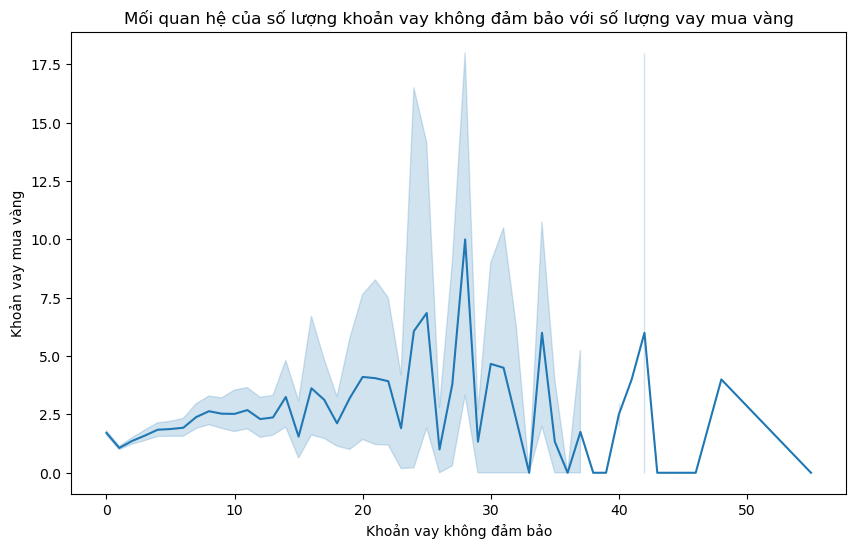

In [82]:
#Unsecured_TL và Gold_TL
plt.figure(figsize=(10, 6))
sns.lineplot(x='Unsecured_TL', y='Gold_TL', data=df1)
plt.title('Mối quan hệ của số lượng khoản vay không đảm bảo với số lượng vay mua vàng')
plt.xlabel('Khoản vay không đảm bảo')
plt.ylabel('Khoản vay mua vàng')
plt.show()

Ngược lại với các khoản vay tiêu dùng, những khách hàng vay tiền để mua vàng lại có xu hướng có các tài sản đảm bảo đủ tốt

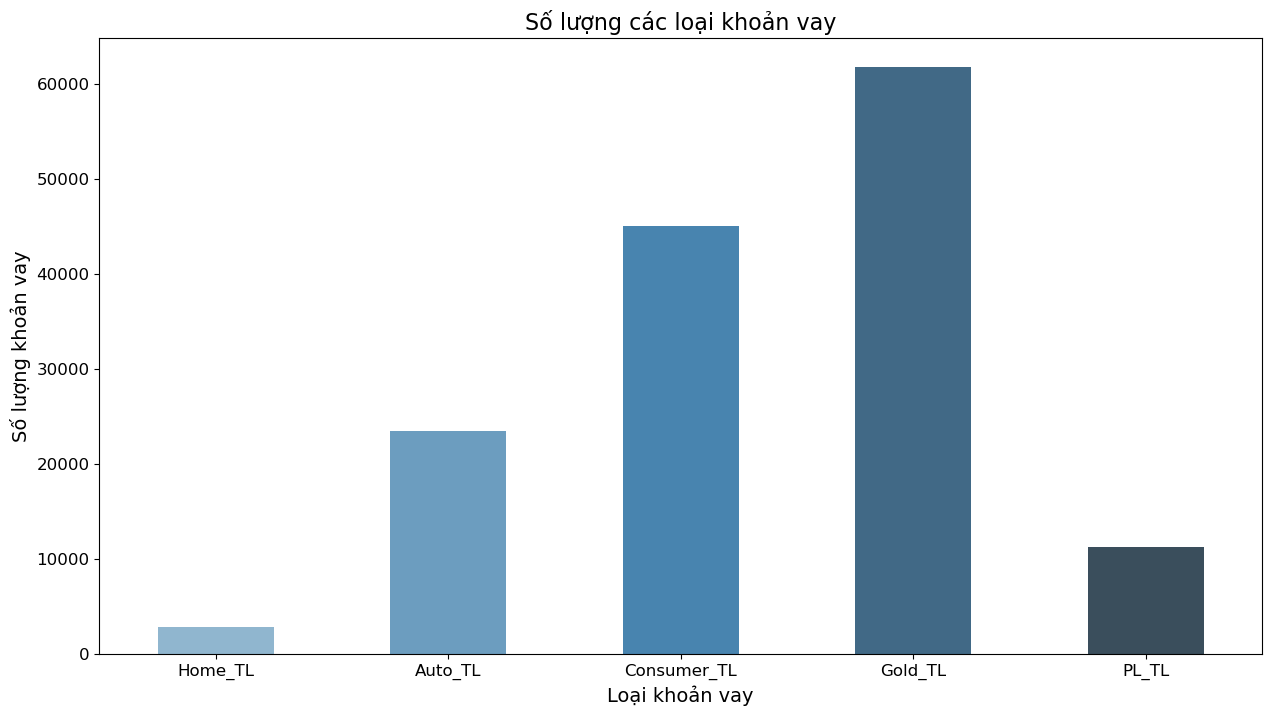

In [86]:
loan_columns = ['Home_TL', 'Auto_TL', 'Consumer_TL', 'Gold_TL', 'PL_TL']
loan_types = df_EDA[loan_columns]

# Tính tổng số lượng khoản vay cho mỗi loại
total_loans = loan_types.sum()

# Vẽ biểu đồ bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x=total_loans.index, y=total_loans.values, palette='Blues_d', width = 0.5)
plt.title('Số lượng các loại khoản vay', fontsize=16)
plt.xlabel('Loại khoản vay', fontsize=14)
plt.ylabel('Số lượng khoản vay', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Có thể thấy số lượng các khoản vay mua vàng chiếm tỉ lệ cao nhất trong cơ cấu các loại khoản vay. Theo sau đó là vay tiêu dùng, vay mua xe,...

Cơ cấu này được đánh giá là khá ổn định bởi rủi ro từ các khoản cho vay mua vàng là khá thấp (như phân tích trước đó), đổi lại doanh nghiệp có thiên hướng tăng rủi ro khi cho vay tiêu dùng để tăng lợi nhuận.

Các khoản vay khác được cơ cấu một cách khá đều.

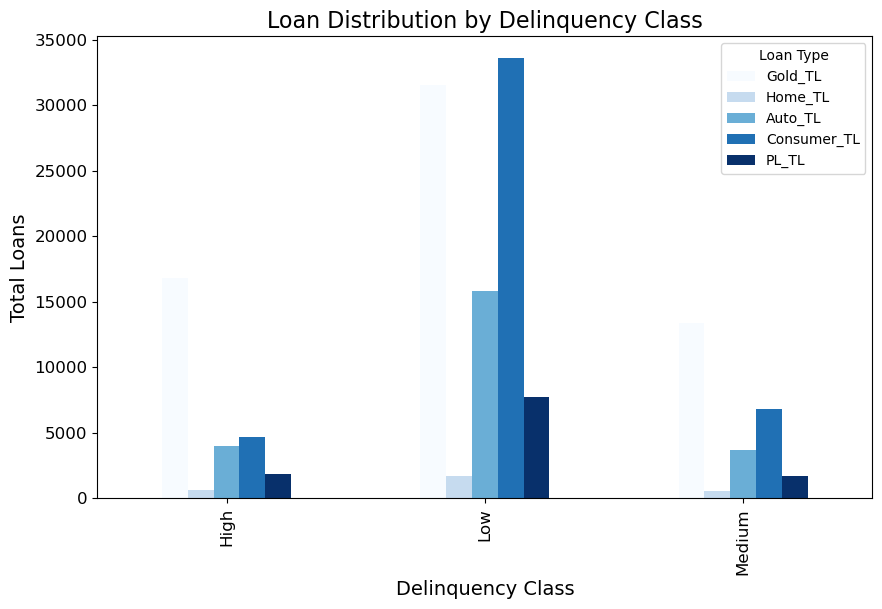

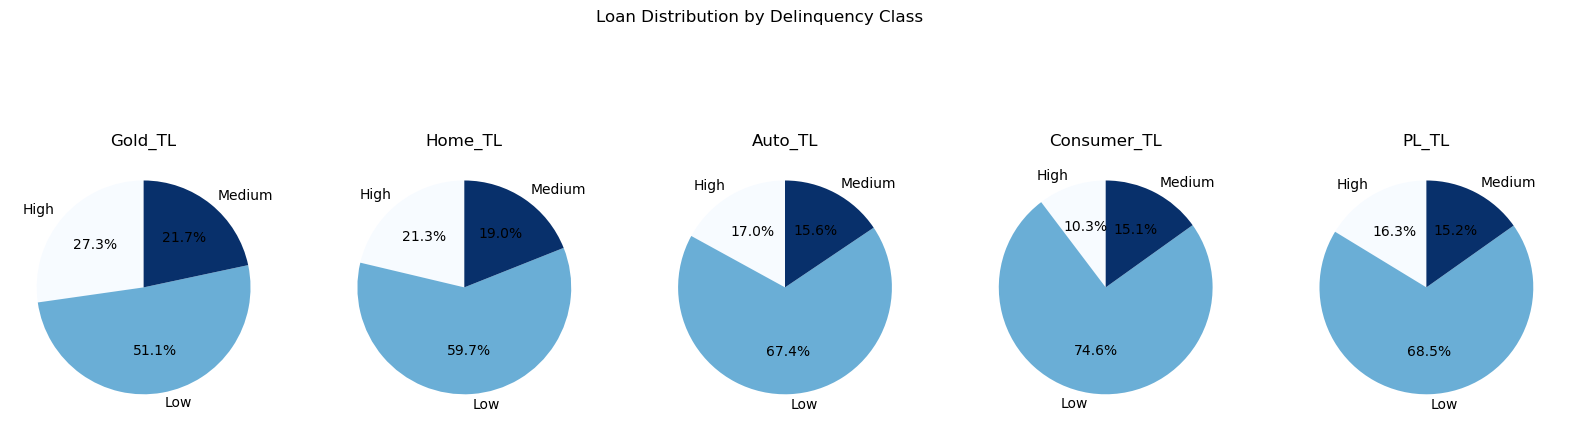

In [88]:
# Biểu đồ cột để phân tích số lần quá hạn thanh toán theo các loại khoản vay
# Xác định ngưỡng hoặc quy tắc phân loại
thresholds = {
    'Low': 1,   # ít quá hạn
    'Medium': 5,  # trung bình quá hạn
    'High': float('inf')  # nhiều quá hạn
}

# Tạo một cột mới để lưu trữ phân loại
df_EDA['Delinquency_Class'] = None

# Phân loại các khoản vay
for index, row in df_EDA.iterrows():
    total_delinquencies = row['num_times_delinquent']
    if total_delinquencies <= thresholds['Low']:
        df_EDA.at[index, 'Delinquency_Class'] = 'Low'
    elif thresholds['Low'] < total_delinquencies <= thresholds['Medium']:
        df_EDA.at[index, 'Delinquency_Class'] = 'Medium'
    else:
        df_EDA.at[index, 'Delinquency_Class'] = 'High'

# Groupby theo cột phân loại và tính tổng của từng loại khoản vay
delinquency_distribution = df_EDA.groupby('Delinquency_Class')[['Gold_TL', 'Home_TL', 'Auto_TL', 'Consumer_TL', 'PL_TL']].sum()

# Vẽ biểu đồ cột
cmap = sns.color_palette("Blues", as_cmap=True)
delinquency_distribution.plot(kind='bar', figsize=(10, 6),colormap=cmap)
plt.title('Loan Distribution by Delinquency Class', fontsize=16)
plt.xlabel('Delinquency Class', fontsize=14)
plt.ylabel('Total Loans', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Loan Type')
plt.show()

# Vẽ biểu đồ pie cho mỗi class
fig, axes = plt.subplots(1, len(delinquency_distribution.columns), figsize=(20, 5))
for i, col in enumerate(delinquency_distribution.columns):
    delinquency_distribution[col].plot(kind='pie', autopct='%1.1f%%', ax=axes[i % len(delinquency_distribution.columns)], startangle=90,colormap=cmap)
    axes[i % len(delinquency_distribution.columns)].set_ylabel('')
    axes[i % len(delinquency_distribution.columns)].set_title(col)
plt.suptitle('Loan Distribution by Delinquency Class', y=1.05)
plt.show()

Số lần quá hạn của các khoản vay đa số đều ở mức thấp (bé hơn hoặc bằng 1 lần).

## Kết Luận

<strong>Đề xuất cho doanh nghiệp</strong>

*   Tập trung vào phát triển các sản phẩm, dịch vụ phù hợp cho nhóm khách hàng chiếm tỉ trọng cao nhất là các học sinh, sinh viên và người mới đi làm với mức thu nhập trung bình thấp.
*   Xây dựng các điều kiện cho vay chặt chẽ hơn đối với các khoản vay có rủi ro trở thành nợ xấu cao (VD: vay tiêu dùng)
*   Phát triển các tính năng nhắc nhở thanh toán trước thời hạn thanh toán phù hợp với từng nhóm đối tượng (VD: đối với nhóm khách hàng lớn tuổi thì nhắc nhở bằng cách gọi điện thoại thay vì thông báo trên app ngân hàng,...)
*   Nghiên cứu mở rộng thêm các nhóm khách hàng chưa được chú trọng như nhóm khách hàng nữ giới (VD: nhu cầu mua sắm đồ gia dụng, quần áo,...) và nhóm khách hàng có thu nhập trung bình - cao và đã có gia đình (các khoản vay hỗ trợ mua xe, mua nhà,...)





# Xây dựng Model

In [133]:
df_train = pd.merge(df1, df2, on='Case_ID', how='inner')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39528 entries, 0 to 39527
Data columns (total 86 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Case_ID                       39528 non-null  int64  
 1   Total_TL                      39528 non-null  int64  
 2   Tot_Closed_TL                 39528 non-null  int64  
 3   Tot_Active_TL                 39528 non-null  int64  
 4   Total_TL_opened_L6M           39528 non-null  int64  
 5   Tot_TL_closed_L6M             39528 non-null  int64  
 6   pct_tl_open_L6M               39528 non-null  float64
 7   pct_tl_closed_L6M             39528 non-null  float64
 8   pct_active_tl                 39528 non-null  float64
 9   pct_closed_tl                 39528 non-null  float64
 10  Total_TL_opened_L12M          39528 non-null  int64  
 11  Tot_TL_closed_L12M            39528 non-null  int64  
 12  pct_tl_open_L12M              39528 non-null  float64
 13  p

In [135]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 86 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Case_ID                       1000 non-null   int64  
 1   Total_TL                      1000 non-null   float64
 2   Tot_Closed_TL                 1000 non-null   float64
 3   Tot_Active_TL                 1000 non-null   float64
 4   Total_TL_opened_L6M           1000 non-null   float64
 5   Tot_TL_closed_L6M             1000 non-null   float64
 6   pct_tl_open_L6M               1000 non-null   float64
 7   pct_tl_closed_L6M             1000 non-null   float64
 8   pct_active_tl                 1000 non-null   float64
 9   pct_closed_tl                 1000 non-null   float64
 10  Total_TL_opened_L12M          1000 non-null   float64
 11  Tot_TL_closed_L12M            1000 non-null   float64
 12  pct_tl_open_L12M              1000 non-null   float64
 13  pct_

In [137]:
# Kết hợp cả file predict vào để cleanning cho cùng định dạng , khi chia train-test thì sẽ tách ra lại
df = pd.concat([df_train, df_predict])

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40528 entries, 0 to 999
Data columns (total 86 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Case_ID                       40528 non-null  int64  
 1   Total_TL                      40528 non-null  float64
 2   Tot_Closed_TL                 40528 non-null  float64
 3   Tot_Active_TL                 40528 non-null  float64
 4   Total_TL_opened_L6M           40528 non-null  float64
 5   Tot_TL_closed_L6M             40528 non-null  float64
 6   pct_tl_open_L6M               40528 non-null  float64
 7   pct_tl_closed_L6M             40528 non-null  float64
 8   pct_active_tl                 40528 non-null  float64
 9   pct_closed_tl                 40528 non-null  float64
 10  Total_TL_opened_L12M          40528 non-null  float64
 11  Tot_TL_closed_L12M            40528 non-null  float64
 12  pct_tl_open_L12M              40528 non-null  float64
 13  pct_tl_c

## Data cleanning trước khi huấn luyện model

In [141]:
# Danh sách các biến không cần thiết cần loại bỏ
unnecessary_columns = ['pct_tl_open_L6M', 'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl','pct_tl_open_L12M',
                       'pct_tl_closed_L12M','pct_of_active_TLs_ever', 'pct_opened_TLs_L6m_of_L12m', 'pct_currentBal_all_TL',
                       'pct_PL_enq_L6m_of_L12m', 'pct_CC_enq_L6m_of_L12m', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever']

# Loại bỏ các biến không cần thiết từ dataframe
df = df.drop(columns=unnecessary_columns)

In [143]:
len(df.columns[(df == -99999).any()])

22

In [145]:
# Thay -99999 thành Nan
df.replace(-99999, np.nan, inplace=True)

In [147]:
# Điền Nan là trung bình của cột đó

numeric_columns = df.select_dtypes(include=[np.number]).columns # Những cột có kiểu dữ liệu là int, float
non_numeric_columns = df.columns.difference(numeric_columns)# Những cột có kiểu dữ liệu là object

df_numeric = df[numeric_columns]
df_non_numeric = df[non_numeric_columns]

# Thực hiện tính toán trung bình chỉ trên các cột có thể tính trung bình
df = df_numeric.fillna(df_numeric.mean())

# Gắn lại các cột không thể tính trung bình vào DataFrame
df[non_numeric_columns] = df_non_numeric
df.head()

,Case_ID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,Total_TL_opened_L12M,Tot_TL_closed_L12M,Tot_Missed_Pmnt,Auto_TL,...,PL_Flag,max_unsec_exposure_inPct,HL_Flag,GL_Flag,Approved_Flag,EDUCATION,GENDER,MARITALSTATUS,first_prod_enq2,last_prod_enq2
0,1,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,29.996101,0.0,0.0,P2,12TH,M,Married,ConsumerLoan,ConsumerLoan
1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,29.996101,0.0,0.0,P2,UNDER GRADUATE,M,Married,others,others
2,3,8.0,6.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,29.996101,1.0,0.0,P2,GRADUATE,M,Married,others,CC
3,4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,29.996101,0.0,0.0,P2,12TH,M,Married,others,others
4,5,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.833000,0.0,0.0,P2,GRADUATE,M,Single,PL,PL


In [149]:
df["MARITALSTATUS"].unique()

array(['Married', 'Single'], dtype=object)

In [151]:
# mapping 2 biến MARITALSTATUS và GENDER thành số

MARITALSTATUS_mapping = {'Married': 1, 'Single': 0}
df["MARITALSTATUS"] = df["MARITALSTATUS"].map(MARITALSTATUS_mapping)

GENDER_mapping = {'M': 1, 'F': 0}
df["GENDER"] = df["GENDER"].map(GENDER_mapping)

In [153]:
# one hot encoder 3  biến [ 'EDUCATION', 'last_prod_enq2' , 'first_prod_enq2' ]
df = pd.get_dummies(df, columns=[ 'EDUCATION', 'last_prod_enq2', 'first_prod_enq2'])

In [155]:
df.replace(True, 1, inplace=True)
df.replace(False, 0, inplace=True)

In [157]:
df["Approved_Flag"].unique()

array(['P2', 'P4', 'P3', 'P1', nan], dtype=object)

In [159]:
# mapping nhãn thành số
category_mapping = {'P1': 0, 'P2': 1, 'P3': 2, 'P4': 3}
df["Approved_Flag"] = df["Approved_Flag"].map(category_mapping)

In [161]:
df.isnull().sum()

Case_ID                         0
Total_TL                        0
Tot_Closed_TL                   0
Tot_Active_TL                   0
Total_TL_opened_L6M             0
                               ..
first_prod_enq2_CC              0
first_prod_enq2_ConsumerLoan    0
first_prod_enq2_HL              0
first_prod_enq2_PL              0
first_prod_enq2_others          0
Length: 89, dtype: int64

## Huấn luyện và đánh giá Model

In [163]:
x = df.drop("Approved_Flag",axis = 1)
y  = df["Approved_Flag"]

In [165]:
scaler = MinMaxScaler()
# Chuẩn hóa từng cột
for column in x.columns:
    x[column] = scaler.fit_transform(x[[column]])

In [167]:
# x[:len(df_train)],y[:len(df_train)] là  vì trong x chứa cả file predict nữa, lên chỉ lấy tới len(df_train)
x_train, x_test, y_train, y_test = train_test_split(x[:len(df_train)],y[:len(df_train)], test_size = 0.2, random_state = 15, stratify = y[:len(df_train)])

In [37]:
# x[len(df_train):] là phần data cần predict trong dataframe x ( là df mà đã drop đi cột Approved_Flag)
x_predict = x[len(df_train):]

In [169]:
# Hàm đánh giá
def EvaluateModel( y_test, y_pred):
    display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1, 2,3])
    display.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Tính những thông số chung
    print('Classification Report: \n', classification_report(y_test, y_pred))
    
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)
    y_true_onehot = label_binarizer.transform(y_test)
    y_pred_onehot = label_binarizer.transform(y_pred)

    auc_score = roc_auc_score(y_true_onehot, y_pred_onehot, average='micro', multi_class="ovr")
    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, average='micro')    

    print('Accuracy: %.3f' % accuracy)
    print('F1-Score: %.3f' % f1score)
    print('AUC: %.3f' % auc_score)
    print('Metric : ', 0.3 * accuracy + 0.3 * f1score + 0.4*auc_score)

### Logistic regression

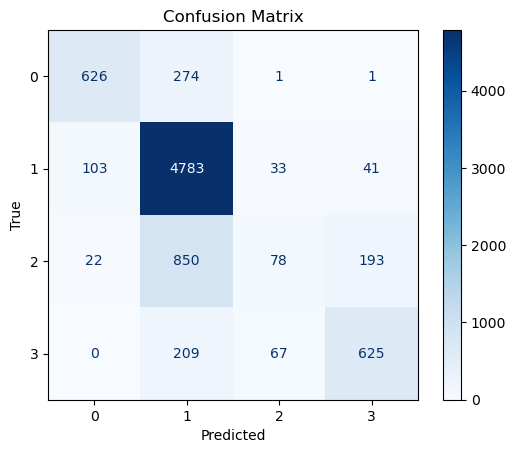

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.83      0.69      0.76       902
         1.0       0.78      0.96      0.86      4960
         2.0       0.44      0.07      0.12      1143
         3.0       0.73      0.69      0.71       901

    accuracy                           0.77      7906
   macro avg       0.69      0.61      0.61      7906
weighted avg       0.73      0.77      0.73      7906

Accuracy: 0.773
F1-Score: 0.773
AUC: 0.849
Metric :  0.8033392360232735


In [43]:
# chạy mô hình LogisticRegression()
model_reg = LogisticRegression()
model_reg.fit(x_train,y_train)
y_pred = model_reg.predict(x_test)
EvaluateModel(y_test, y_pred)

### Artificial Neural networks

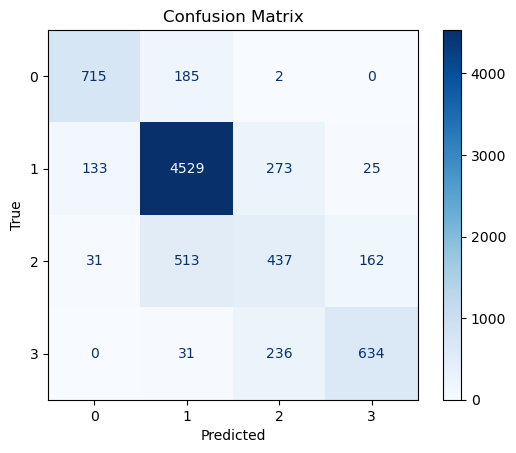

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       902
         1.0       0.86      0.91      0.89      4960
         2.0       0.46      0.38      0.42      1143
         3.0       0.77      0.70      0.74       901

    accuracy                           0.80      7906
   macro avg       0.73      0.70      0.71      7906
weighted avg       0.79      0.80      0.79      7906

Accuracy: 0.799
F1-Score: 0.799
AUC: 0.866
Metric :  0.8255923770975631


In [45]:
# chạy mô hình ANN()
model_neural = MLPClassifier()
model_neural.fit(x_train,y_train)
y_pred = model_neural.predict(x_test)
EvaluateModel( y_test, y_pred)

### Random forest

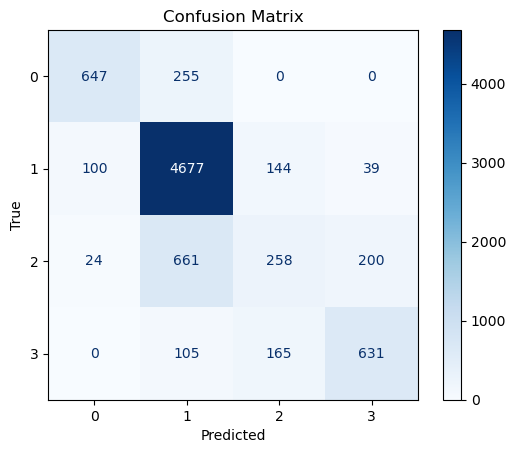

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.72      0.77       902
         1.0       0.82      0.94      0.88      4960
         2.0       0.46      0.23      0.30      1143
         3.0       0.73      0.70      0.71       901

    accuracy                           0.79      7906
   macro avg       0.71      0.65      0.67      7906
weighted avg       0.76      0.79      0.76      7906

Accuracy: 0.786
F1-Score: 0.786
AUC: 0.857
Metric :  0.814410995868117


In [99]:
# chạy mô hình Random Forest()
model_RDF = RandomForestClassifier()
model_RDF.fit(x_train,y_train)
y_pred = model_RDF.predict(x_test)
EvaluateModel(y_test, y_pred)

### XGboost

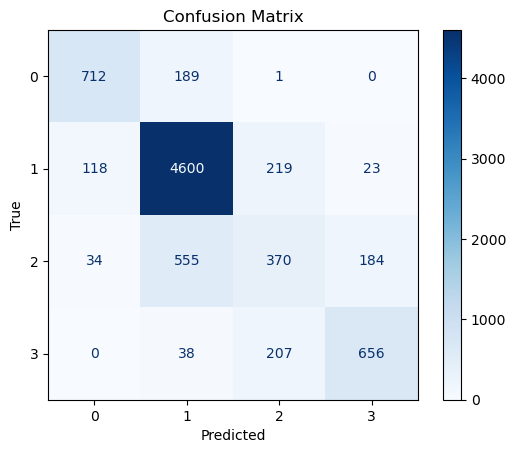

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.82      0.79      0.81       902
         1.0       0.85      0.93      0.89      4960
         2.0       0.46      0.32      0.38      1143
         3.0       0.76      0.73      0.74       901

    accuracy                           0.80      7906
   macro avg       0.73      0.69      0.71      7906
weighted avg       0.78      0.80      0.79      7906

Accuracy: 0.802
F1-Score: 0.802
AUC: 0.868
Metric :  0.8281136689434185


In [47]:
# chạy mô hình XGboost() 
model_xgb = XGBClassifier()
model_xgb.fit(x_train,y_train)
y_pred = model_xgb.predict(x_test)
EvaluateModel(y_test, y_pred)

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4984
[LightGBM] [Info] Number of data points in the train set: 31622, number of used features: 86
[LightGBM] [Info] Start training from score -2.170699
[LightGBM] [Info] Start training from score -0.466203
[LightGBM] [Info] Start training from score -1.934340
[LightGBM] [Info] Start training from score -2.171531


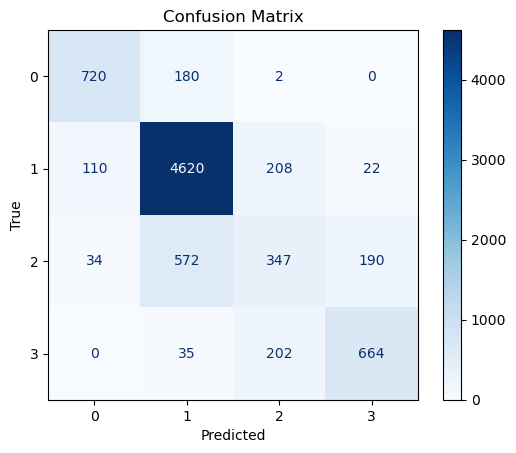

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.83      0.80      0.82       902
         1.0       0.85      0.93      0.89      4960
         2.0       0.46      0.30      0.36      1143
         3.0       0.76      0.74      0.75       901

    accuracy                           0.80      7906
   macro avg       0.73      0.69      0.70      7906
weighted avg       0.78      0.80      0.79      7906

Accuracy: 0.803
F1-Score: 0.803
AUC: 0.869
Metric :  0.8295387469432498


In [48]:
# chạy mô hình LightGBM() 2
model_lgbm = LGBMClassifier()
model_lgbm.fit(x_train,y_train)
y_pred = model_lgbm.predict(x_test)
EvaluateModel(y_test, y_pred)

### Kết hợp 3 model Neural networks, XGboost, LightGBM 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4984
[LightGBM] [Info] Number of data points in the train set: 31622, number of used features: 86
[LightGBM] [Info] Start training from score -2.170699
[LightGBM] [Info] Start training from score -0.466203
[LightGBM] [Info] Start training from score -1.934340
[LightGBM] [Info] Start training from score -2.171531


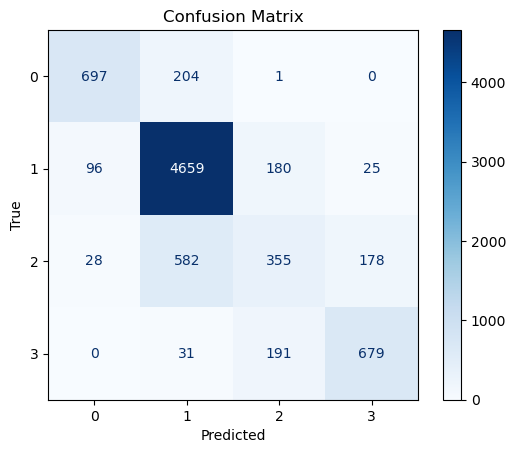

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.77      0.81       902
         1.0       0.85      0.94      0.89      4960
         2.0       0.49      0.31      0.38      1143
         3.0       0.77      0.75      0.76       901

    accuracy                           0.81      7906
   macro avg       0.74      0.69      0.71      7906
weighted avg       0.79      0.81      0.79      7906

Accuracy: 0.808
F1-Score: 0.808
AUC: 0.872
Metric :  0.8338139809427438


In [53]:
estimators = [
    ('lgbm', model_lgbm),
    ('xgb', model_xgb),
    ('neural', model_neural)
]
model_combined = VotingClassifier(estimators=estimators, voting='soft')
model_combined.fit(x_train, y_train)
y_pred_combined = model_combined.predict(x_test)
EvaluateModel(y_test, y_pred_combined)

### Kết hợp 3 model Random forest, XGboost, LightGBM 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4984
[LightGBM] [Info] Number of data points in the train set: 31622, number of used features: 86
[LightGBM] [Info] Start training from score -2.170699
[LightGBM] [Info] Start training from score -0.466203
[LightGBM] [Info] Start training from score -1.934340
[LightGBM] [Info] Start training from score -2.171531


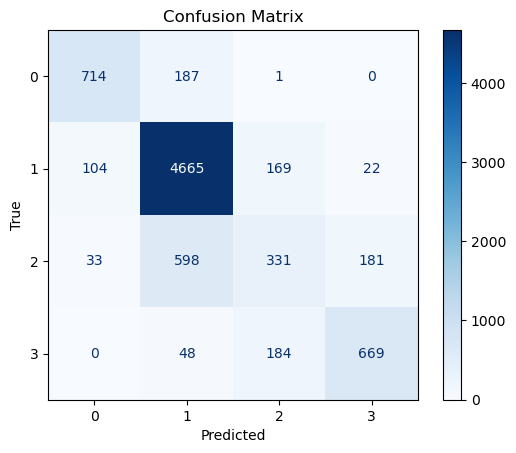

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       902
         1.0       0.85      0.94      0.89      4960
         2.0       0.48      0.29      0.36      1143
         3.0       0.77      0.74      0.75       901

    accuracy                           0.81      7906
   macro avg       0.73      0.69      0.71      7906
weighted avg       0.79      0.81      0.79      7906

Accuracy: 0.807
F1-Score: 0.807
AUC: 0.871
Metric :  0.8326081457121175


In [55]:
estimators = [
    ('lgbm', model_lgbm),
    ('xgb', model_xgb),
    ('rdf', model_RDF)
]
model_combined = VotingClassifier(estimators=estimators, voting='soft')
model_combined.fit(x_train, y_train)
y_pred_combined = model_combined.predict(x_test)
EvaluateModel(y_test, y_pred_combined)

### Kết luận

<strong>Logistic regression </strong>
Accuracy: 0.773
F1-Score: 0.773
AUC: 0.849
Me﻿tric : 0.803

<strong>Artificial neural network </strong>
Accuracy: 0.799
F1-Score: 0.799
AUC: 0.866
Me﻿tric : 0.826


<strong>Random forest </strong>
Accuracy: 0.786
F1-Score: 0.786
AUC: 0.857
Me﻿tric : 0.814

<strong>Xgboost </strong>
Accuracy: 0.802
F1-Score: 0.802
AUC: 0.868
Me﻿tric : 0.828


<strong>LightGBM</strong>
Accuracy: 0.803
F1-Score: 0.803
AUC: 0.869
Me﻿tric : 0.83

<strong> Model kết hợp Random forest - Xgboost - LighGBM  </strong>
Accuracy: 0.807
F1-Score: 0.807
AUC: 0.871
Me﻿tric : 0.833


<strong>Model kết hợp Neural networks - Xgboost - LighGBM </strong>
Accuracy: 0.808
F1-Score: 0.808
AUC: 0.873
Me﻿tric : 0.834

<strong>=> Model kết hợp Neural networks - Xgboost - LighGBM và Model kết hợp Random forest - Xgboost - LighGBM cho ra chỉ số đánh giá Metric cao nhất</strong>


# Dự đoán kết quả cho file test.csv bằng model kết hợp Random forest - Xgboost - LighGBM

In [93]:
df_result = pd.read_excel(r"D:\Đề thi chung kết\submission.xlsx")
df_result = df_result.drop("Approved_Flag",axis = 1)
df_result["Approved_Flag"] =model_combined.predict(x_predict)
category_mapping_back = {0:'P1', 1:'P2', 2:'P3', 3:'P4'}
df_result["Approved_Flag"] = df_result["Approved_Flag"].map(category_mapping_back)
df_result.to_excel("D:\submission.xlsx", index = False)

In [95]:
df_result

,Case_ID,Approved_Flag
0,990000,P3
1,990001,P3
2,990002,P2
3,990003,P2
4,990004,P2
...,...,...
995,990995,P2
996,990996,P2
997,990997,P3
998,990998,P2
